In [249]:
import pandas as pd
import sklearn as sk
import numpy as np
import random
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import itertools
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score


# Read data file into pandas

In [3]:
filename = "cs-training.csv"
data = pd.read_csv(filename)

# The dataset is large; simply remove rows with NA, irregularities, outliers:

In [4]:
data = data.dropna(axis=0)

In [5]:
#Drop the unnecessary and unlabaled index column
data = data.drop(labels=["Unnamed: 0"], axis=1)

In [6]:
#There are a number of rows where the values in the MonthlyIncome column is either 0 or 1, while the accompanying 
#DebtRatio values are very large numbers (actually they appear to be the mislabeled Monthly Incomes). Since we 
#are uncertain and have sufficient data to do so, just drop these rows.
data = data.drop(data[data.MonthlyIncome <= 1].index)

In [7]:
#While it may be possible through a technical fluke to have this value be quite high, only severe outliers 
#have it greater than 3 
data = data.drop(data[data.RevolvingUtilizationOfUnsecuredLines > 3].index)

In [8]:
#21 is the lowest age, so remove rows with lower ages
data = data.drop(data[data.age < 21].index)

In [9]:
#Remove rows with NumberOfNDaysLate == 96 or 98; must be a code
data = data.drop(data[data.NumberOfTimes90DaysLate > 90].index)

In [10]:
#Make sure there are no negative values
sum(n < 0 for n in data.values.flatten())

0

In [11]:
#This is the list of features I will use; a future iteration would see me engineering new ones
list(data.columns)

['SeriousDlqin2yrs',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [ ]:
columns_readable = ['Serious Delinquency in 2 yrs (yes/no)','% Credit Used',
 'Age',
 'No. Times 1-2 months late',
 'Ratio Debt to Income',
 'Monthly Income',
 'No. Of Open Credit Lines',
 'No. Of Times 3 months late',
 'No. Of Real Estate Loans',
 'No. Of Times 2-3 months late',
 'No. Of Dependents']

# Here I do some exploratory plots of data to make sure I haven't left in any real outliers

(array([  5.48490000e+04,   1.55680000e+04,   1.06890000e+04,
          8.19800000e+03,   6.70200000e+03,   6.38100000e+03,
          1.39480000e+04,   7.60000000e+02,   2.19000000e+02,
          1.26000000e+02,   7.10000000e+01,   5.20000000e+01,
          3.80000000e+01,   3.40000000e+01,   2.10000000e+01,
          8.00000000e+00,   5.00000000e+00,   5.00000000e+00,
          5.00000000e+00,   3.00000000e+00]),
 array([-0.004 ,  0.1462,  0.2964,  0.4466,  0.5968,  0.747 ,  0.8972,
         1.0474,  1.1976,  1.3478,  1.498 ,  1.6482,  1.7984,  1.9486,
         2.0988,  2.249 ,  2.3992,  2.5494,  2.6996,  2.8498,  3.    ]),
 <a list of 20 Patch objects>)

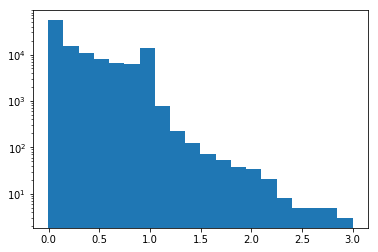

In [13]:
plt.yscale('log', nonposy='clip')
plt.hist(data['RevolvingUtilizationOfUnsecuredLines'], bins=20, range=[-0.004, 3])

(array([  1.43300000e+03,   4.07600000e+03,   8.48100000e+03,
          7.83400000e+03,   1.24620000e+04,   1.13960000e+04,
          1.53600000e+04,   1.14020000e+04,   1.31160000e+04,
          1.03150000e+04,   8.53800000e+03,   4.72200000e+03,
          4.20000000e+03,   2.24700000e+03,   1.37500000e+03,
          5.57000000e+02,   1.48000000e+02,   1.50000000e+01,
          5.00000000e+00,   0.00000000e+00]),
 array([  20. ,   24.5,   29. ,   33.5,   38. ,   42.5,   47. ,   51.5,
          56. ,   60.5,   65. ,   69.5,   74. ,   78.5,   83. ,   87.5,
          92. ,   96.5,  101. ,  105.5,  110. ]),
 <a list of 20 Patch objects>)

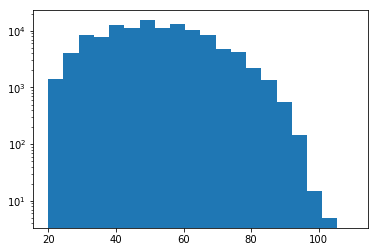

In [14]:
plt.yscale('log', nonposy='clip')
plt.hist(data['age'],bins=20,range=[20,110])

(array([  5.10800000e+03,   2.00000000e+01,   6.00000000e+00,
          5.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00]),
 array([   1.  ,   25.95,   50.9 ,   75.85,  100.8 ,  125.75,  150.7 ,
         175.65,  200.6 ,  225.55,  250.5 ,  275.45,  300.4 ,  325.35,
         350.3 ,  375.25,  400.2 ,  425.15,  450.1 ,  475.05,  500.  ]),
 <a list of 20 Patch objects>)

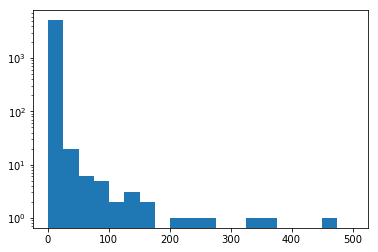

In [16]:
plt.yscale('log', nonposy='clip')
plt.hist(data['DebtRatio'],bins=20,range=[1,500])

(array([ 15521.,   7064.,   8346.,   9391.,  10044.,  10182.,   9478.,
          8495.,   7152.,   5959.,   4727.,   3654.,   2945.,   2475.,
          1908.,   1482.,   1188.,   1009.,    853.,    665.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]),
 <a list of 20 Patch objects>)

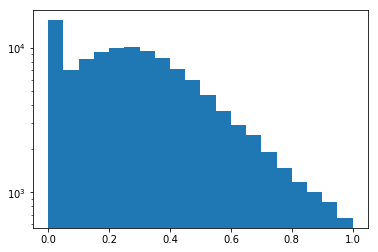

In [17]:
plt.yscale('log', nonposy='clip')
plt.hist(data['DebtRatio'],bins=20,range=[0,1])

(array([  449.,  1722.,  2606.,  3806.,  5640.,  6747.,  7719.,  7202.,
         8298.,  6484.,  8254.,  5758.,  6401.,  5011.,  4884.,  4213.,
         4404.,  3071.,  3021.,  3730.]),
 array([     0.,    500.,   1000.,   1500.,   2000.,   2500.,   3000.,
          3500.,   4000.,   4500.,   5000.,   5500.,   6000.,   6500.,
          7000.,   7500.,   8000.,   8500.,   9000.,   9500.,  10000.]),
 <a list of 20 Patch objects>)

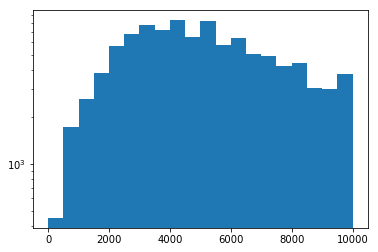

In [21]:
plt.yscale('log', nonposy='clip')
plt.hist(data['MonthlyIncome'],bins=20,range=[0,10000])

(array([  8.79240000e+04,   1.77100000e+04,   8.54200000e+03,
          2.60600000e+03,   6.72000000e+02,   1.48000000e+02,
          4.80000000e+01,   2.20000000e+01,   4.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00]),
 array([  0.  ,   1.05,   2.1 ,   3.15,   4.2 ,   5.25,   6.3 ,   7.35,
          8.4 ,   9.45,  10.5 ,  11.55,  12.6 ,  13.65,  14.7 ,  15.75,
         16.8 ,  17.85,  18.9 ,  19.95,  21.  ]),
 <a list of 20 Patch objects>)

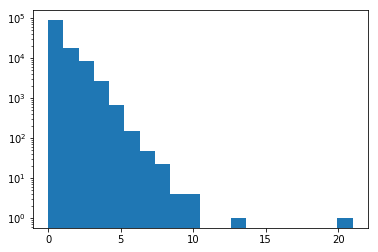

In [24]:
plt.yscale('log', nonposy='clip')
plt.hist(data['NumberOfDependents'],bins=20,range=[0,21])

(array([  1.11640000e+05,   4.74400000e+03,   8.99000000e+02,
          2.64000000e+02,   8.30000000e+01,   2.80000000e+01,
          1.60000000e+01,   5.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 array([  0.  ,   0.95,   1.9 ,   2.85,   3.8 ,   4.75,   5.7 ,   6.65,
          7.6 ,   8.55,   9.5 ,  10.45,  11.4 ,  12.35,  13.3 ,  14.25,
         15.2 ,  16.15,  17.1 ,  18.05,  19.  ]),
 <a list of 20 Patch objects>)

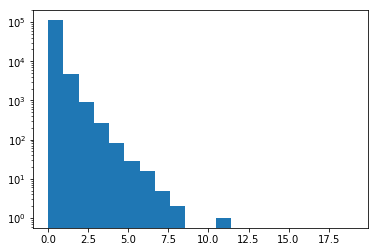

In [26]:
plt.yscale('log', nonposy='clip')
plt.hist(data['NumberOfTime60-89DaysPastDueNotWorse'],bins=20,range=[0,19])

(array([  8.20400000e+03,   2.46940000e+04,   3.12450000e+04,
          2.41500000e+04,   1.44660000e+04,   7.69200000e+03,
          3.79900000e+03,   1.78500000e+03,   8.51000000e+02,
          4.04000000e+02,   1.90000000e+02,   9.20000000e+01,
          3.40000000e+01,   2.30000000e+01,   1.50000000e+01,
          1.10000000e+01,   1.20000000e+01,   6.00000000e+00,
          6.00000000e+00,   3.00000000e+00]),
 array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,
         33.,  36.,  39.,  42.,  45.,  48.,  51.,  54.,  57.,  60.]),
 <a list of 20 Patch objects>)

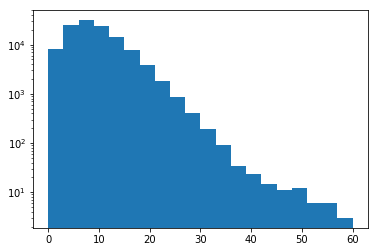

In [29]:
plt.yscale('log', nonposy='clip')
plt.hist(data['NumberOfOpenCreditLinesAndLoans'],bins=20,range=[0,60])

(array([  1.09291000e+05,   7.71600000e+03,   5.00000000e+02,
          1.11000000e+02,   3.80000000e+01,   1.20000000e+01,
          5.00000000e+00,   2.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00]),
 array([  0.,   3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,
         33.,  36.,  39.,  42.,  45.,  48.,  51.,  54.,  57.,  60.]),
 <a list of 20 Patch objects>)

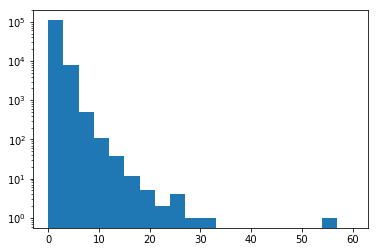

In [31]:
plt.yscale('log', nonposy='clip')
plt.hist(data['NumberRealEstateLoansOrLines'],bins=20,range=[0,60])

In [69]:
dlq = (data.SeriousDlqin2yrs == 1)
resp = (data.SeriousDlqin2yrs == 0)

In [78]:
np.linspace(0,2,20)

array([ 0.        ,  0.10526316,  0.21052632,  0.31578947,  0.42105263,
        0.52631579,  0.63157895,  0.73684211,  0.84210526,  0.94736842,
        1.05263158,  1.15789474,  1.26315789,  1.36842105,  1.47368421,
        1.57894737,  1.68421053,  1.78947368,  1.89473684,  2.        ])

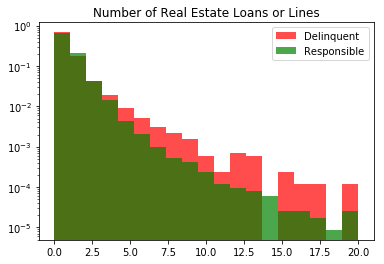

In [105]:
# plt.yscale('log', nonposy='clip')
bins = np.linspace(0, 20, 20)
# plt.hist(dlq & data['NumberRealEstateLoansOrLines'],bins=20,range=[0,2], alpha=0.3, normed=True)
# plt.hist(resp & data['NumberRealEstateLoansOrLines'],bins=20,range=[0,2], alpha=0.3, normed=True)
plt.title("Number of Real Estate Loans or Lines")
plt.hist(data['NumberRealEstateLoansOrLines'][dlq], bins=bins, alpha=0.7, normed=True, color='red', log=True, label='Delinquent')
plt.hist(data['NumberRealEstateLoansOrLines'][resp], bins=bins, alpha=0.7, normed=True, color='green',log=True, label='Responsible')
plt.legend(loc='best')


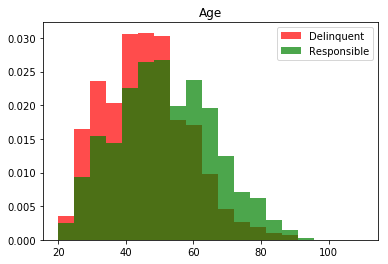

In [106]:
bins = np.linspace(20, 110, 20)
plt.title("Age")
plt.hist(data['age'][dlq], bins=bins, alpha=0.7, normed=True, color='red', label='Delinquent')
plt.hist(data['age'][resp], bins=bins, alpha=0.7, normed=True, color='green', label='Responsible')
plt.legend(loc='best')

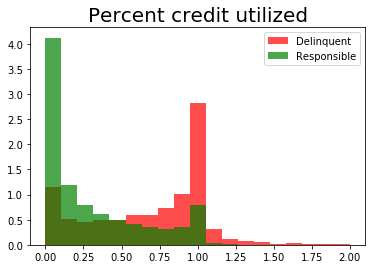

In [111]:
bins = np.linspace(0, 2, 20)
plt.title("Percent credit utilized",fontsize=20)
plt.hist(data['RevolvingUtilizationOfUnsecuredLines'][dlq], bins=bins, alpha=0.7, normed=True, color='red', label='Delinquent')
plt.hist(data['RevolvingUtilizationOfUnsecuredLines'][resp], bins=bins, alpha=0.7, normed=True, color='green', label='Responsible')
plt.legend(loc='best')

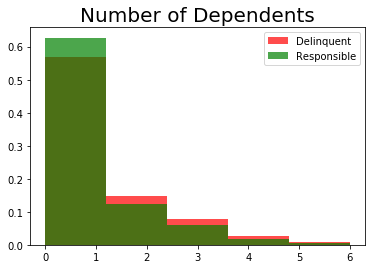

In [118]:
bins = np.linspace(0, 6, 6)
plt.title("Number of Dependents",fontsize=20)
plt.hist(data['NumberOfDependents'][dlq], bins=bins, alpha=0.7, normed=True, color='red', label='Delinquent')
plt.hist(data['NumberOfDependents'][resp], bins=bins, alpha=0.7, normed=True, color='green', label='Responsible')
plt.legend(loc='best')

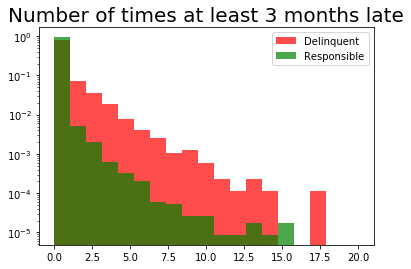

In [121]:
bins = np.linspace(0, 20, 20)
plt.title("Number of times at least 3 months late",fontsize=20)
plt.hist(data['NumberOfTimes90DaysLate'][dlq], bins=bins, alpha=0.7, normed=True, color='red', log=True, label='Delinquent')
plt.hist(data['NumberOfTimes90DaysLate'][resp], bins=bins, alpha=0.7, normed=True, color='green',log=True, label='Responsible')
plt.legend(loc='best')

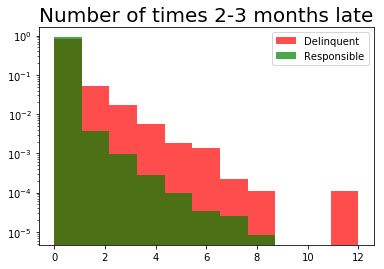

In [126]:
bins = np.linspace(0, 12, 12)
plt.title("Number of times 2-3 months late",fontsize=20)
plt.hist(data['NumberOfTime60-89DaysPastDueNotWorse'][dlq], bins=bins, alpha=0.7, normed=True, color='red', log=True, label='Delinquent')
plt.hist(data['NumberOfTime60-89DaysPastDueNotWorse'][resp], bins=bins, alpha=0.7, normed=True, color='green',log=True, label='Responsible')
plt.legend(loc='best')

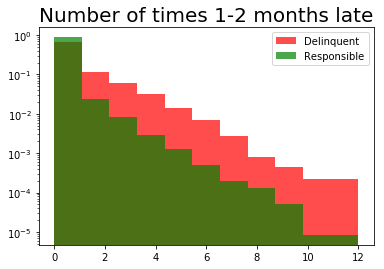

In [129]:
bins = np.linspace(0, 12, 12)
plt.title("Number of times 1-2 months late",fontsize=20)
plt.hist(data['NumberOfTime30-59DaysPastDueNotWorse'][dlq], bins=bins, alpha=0.7, normed=True, color='red', log=True, label='Delinquent')
plt.hist(data['NumberOfTime30-59DaysPastDueNotWorse'][resp], bins=bins, alpha=0.7, normed=True, color='green',log=True, label='Responsible')
plt.legend(loc='best')

# Now, use imb-learn to do a random undersampling 

In [219]:
from collections import Counter
from imblearn.ensemble import EasyEnsemble 


In [178]:
from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=1, train_size=0.6, test_size=.4,
                  random_state=0)

In [179]:
#So we have 70609 rows in our unbalanced training set
train = data.iloc[train_index]
train.shape

(70609, 11)

In [180]:
#And 47073 rows in our test set.
test = data.iloc[test_index]
test.shape

(47073, 11)

In [221]:
#Separating data into X and y, train and test
featureHeaders = list(data.keys())
targetFeature = 'SeriousDlqin2yrs'
featureHeaders.remove(targetFeature)
X_data = data[featureHeaders]
y_data = data[targetFeature]

X_train = train[featureHeaders]
y_train = train[targetFeature]

X_test = test[featureHeaders]
y_test = test[targetFeature]

In [231]:
#Finally, balance our training set. The number of rows drops to 9830, around an 87% loss.
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 4915), (1, 4915)]


# Now train a Random Forest on this dataset

In [224]:
def run_RF_fit(X_train,y_train):
    '''
    The function that trains the random forest. The hyperparameters of this classifier were determined via a grid search.
    '''
    rf = RandomForestClassifier(max_depth=8,n_estimators=100)
    rf.fit(X_train, y_train)
    return rf

In [232]:
rf = run_RF_fit(X_resampled,y_resampled)

y_pred = rf.predict_proba(X_test)[:,1]
print (rf.score(X_test, y_test)) # Overall accuracy score

0.772247360483


# Now start plotting some evaluation metrics

In [192]:
def show_roc_curve(y_test, y_pred):
    '''
    Displays the ROC curve and AUC for a model.
    '''
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc=auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC=%0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')

In [193]:
def plot_confusion_matrix(cm,title='Confusion matrix',normalize=True,cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    classes = ['Responsible','Delinquent']
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(int(cm[i, j]), fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [246]:
def print_classification_report(y_test, y_pred, threshold_cut=0.5):
    '''
    Prints the classification report for a model. Allows for non-binary predictions with a threshold cut.
    '''
    y_pred_test = y_pred > threshold_cut
    print(classification_report(y_test, y_pred_test))

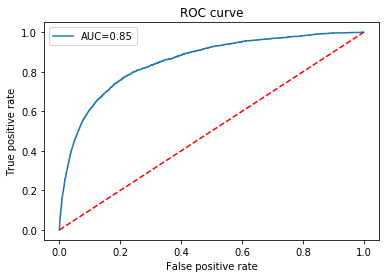

In [234]:
#We want to be very careful with using ROC curves to gauge the effectiveness of a Random Forest, though.
show_roc_curve(y_test,y_pred)

Confusion matrix, without normalization
[[33795 10026]
 [  695  2557]]


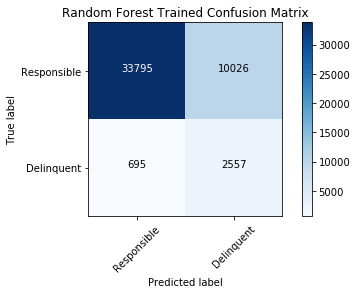

In [236]:
cm_rf = confusion_matrix(y_test, rf.predict(X_test))
plot_confusion_matrix(cm_rf,"Random Forest Trained Confusion Matrix",normalize=False)

In [250]:
print_classification_report(y_test,rf.predict(X_test),0.5)

             precision    recall  f1-score   support

          0       0.98      0.77      0.86     43821
          1       0.20      0.79      0.32      3252

avg / total       0.93      0.77      0.83     47073



In [264]:
def show_global_feature_importance(model,X_train,readable_feature_list, color="indigo"):
    '''
    Displays the feature importance bar graph for a trained random forest. Bar graph is horizontal decreasing, and 
    the feature list is displayed on the y-axis ticks. User can specify color
    '''
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], #There are n_estimators trees in the forest!
             axis=0)
    indices = np.argsort(importances)[::-1]

    arr1 = indices
    arr1inds = arr1.argsort()
    arr2 = np.array(readable_feature_list) 
    sorted_arr2 = arr2[arr1inds[::1]] # This bit of code sorts my plain English list of features according to 
                                      # the order yielded by rf.feature_importances_

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. %s (%f)" % (f + 1, sorted_arr2[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances", fontsize=20)
    plt.barh(range(X_train.shape[1]), importances[indices], color=color, yerr=std[indices], align="center")
    plt.yticks(range(X_train.shape[1]), sorted_arr2, rotation=0, ha='right')
    plt.gca().invert_yaxis()
    plt.xlim([-0.01, importances[0]+0.01]) # Makes sure the plot always fits the longest bar
    plt.gcf().set_size_inches(8,8)
    plt.tick_params(labelsize=20)
    plt.show()

In [294]:
columns_readable.pop(0)
show_global_feature_importance(rf,X_train,columns_readable,"red")

TypeError: 'str' object cannot be interpreted as an integer

# Now that we have a global feature importance, let's investigate local feature importance with LIME

In [271]:
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

In [272]:
# Translating classes '0' and '1' to 'Responsible' and 'Delinquent'. There are probably better names for this
# but better heads than mine will need to help me come up with them.
class_names = ["Responsible","Delinquent"]

# LIME takes numpy arrays instead of pandas dataframes. Saving the pandas in case we want to play with them later.
X_train_df = X_train
X_test_df = X_test

X_train = np.array(X_train)
X_test = np.array(X_test)

In [296]:
readable_feature_list = columns_readable
readable_feature_list

['% Credit Used',
 'Age',
 'No. Times 1-2 months late',
 'Ratio Debt to Income',
 'Monthly Income',
 'No. Of Open Credit Lines',
 'No. Of Times 3 months late',
 'No. Of Real Estate Loans',
 'No. Of Times 2-3 months late',
 'No. Of Dependents']

In [489]:
type(readable_feature_list)

list

In [297]:
# This is the first step of two for LIME functions. Takes the training set, a list of features, and a list of classes.

explainer = LimeTabularExplainer(
    X_train,
    class_names=['Responsible', 'Delinquent'],
    feature_names=readable_feature_list,
    discretize_continuous=True
)

Probability of delinquency:  0.498288367875  for example  43620


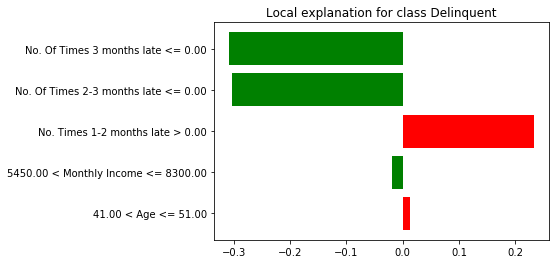

In [443]:
# This is the second and main step. Returns the 5 most important features for the example here we select at random. 
# Randomly finds a set of samples in prediction space, uses the model's predict_proba to weight those that are near 
# the example, then fits a simple decision tree to that local region. The interpretable model used in the local
# regime varies depending on what type of model is inputted.

example = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test[example], rf.predict_proba, num_features=5)
print('Probability of delinquency: ',exp.predict_proba[1],' for example ', example)

fig=exp.as_pyplot_figure() # Pleasantly shows importances as pyplot

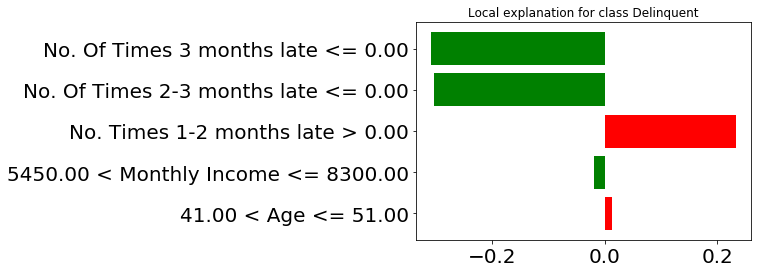

In [444]:
ax = fig.axes
ax[0].tick_params(labelsize=20) # Make the font more readable!
fig
fig.savefig("lime_fig.png",bbox_inches='tight')

In [299]:
# Can also output the important features as a simple list!
reasons = exp.as_list()
print (reasons)

[('No. Of Times 3 months late <= 0.00', -0.31747956457604054), ('No. Of Times 2-3 months late <= 0.00', -0.30093676848062983), ('No. Times 1-2 months late <= 0.00', -0.23018646842585563), ('% Credit Used <= 0.04', -0.15193101889383659), ('Age > 62.00', -0.057312754981500687)]


(0, 3)

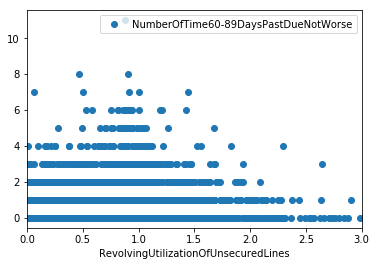

In [374]:
# Noticing that people who are routinely late with payments (though not yet delinquent) also tend to use a high 
# percentage of their credit allowance, even going over the limit (normal limit is 1).
ax = data.plot(x='RevolvingUtilizationOfUnsecuredLines',y='NumberOfTime60-89DaysPastDueNotWorse',style="o")
ax.set_xlim(0,3)

# Finally, we save the model and LIME explainer for use on the web app

In [445]:
import pickle
import dill

def saveVar(variable_to_save, file_name):
    '''
    Saves the machine learning model for use on the web app
    '''
    with open(file_name+'.pickle', "wb") as f:
        pickle.dump(variable_to_save, f)
        
def saveDill(variable_to_save, file_name):
    '''
    Saves the LIME explainer for use on the web app. Same idea as pickle, but works for objects using lambdas, like LIME.
    '''
    with open(file_name+'.dill', 'wb') as f:
        dill.dump(variable_to_save, f)

In [446]:
saveVar(rf, 'Trained_RF')

In [447]:
saveDill(explainer,"Saved_Explainer")

In [460]:
X_data.to_csv("datafile.csv")